In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from dataclasses import dataclass,field

from pipeline.cfg import ConfigTrajPreprocess,ConfigTrajSegmentationClassification

from tracking_data.dataset import Dataset_CentroidTracking,Dataset_TailTracking
from preprocessing.preprocessing import Preprocessed_Traj
from segmentation.segment import Segment
from classification.template_bouts import Knn_Training_Dataset

from preprocessing.preprocessing import create_preprocess_traj
from segmentation.segment import create_segmentation_from_mobility,extract_aligned_traj
from classification.classify import create_classifier

In [3]:
cfg_preprocess = ConfigTrajPreprocess(fps=700)
cfg_segment_classify = ConfigTrajSegmentationClassification(fps=700)

In [4]:
# TODO: Use functools partial instead of create_function...

In [97]:
fps = cfg_preprocess.fps
#tracking_data = Dataset_CentroidTracking(fps=fps,x=x,y=y,body_angle=body_angle)

@dataclass(repr=False)
class PipelineCentroidTracking():

    cfg_preprocess : ConfigTrajPreprocess
    cfg_segment_classify : ConfigTrajSegmentationClassification
    knn_training_dataset: Knn_Training_Dataset = field(init=False)
    
    def __post_init__(self):
        assert cfg_preprocess.fps==cfg_segment_classify.fps, \
            f"fps should be the same in both config"
        self.knn_training_dataset_augmented = Knn_Training_Dataset(fps=self.cfg_preprocess.fps,
                                                         augmentation_delays=np.arange(0,
                                                                                       self.cfg_segment_classify.augment_max_delay,
                                                                                       self.cfg_segment_classify.augment_step_delay),
                                                         ignore_CS=True)
        self.knn_training_dataset = Knn_Training_Dataset(fps=self.cfg_preprocess.fps,
                                                         augmentation_delays=[0],
                                                         ignore_CS=True)
    def preprocess(self):
        return create_preprocess_traj(fps=self.cfg_preprocess.fps,
                                            fc_min=self.cfg_preprocess.freq_cutoff_min,
                                            beta=self.cfg_preprocess.beta,
                                            robust_diff=self.cfg_preprocess.robust_diff,
                                            lag=self.cfg_preprocess.lag_mobility)
    def find_segment(self):
        return create_segmentation_from_mobility(bout_duration=self.cfg_segment_classify.bout_duration,
                                                 prominence=self.cfg_segment_classify.peak_prominence,
                                                 margin_before_peak=self.cfg_segment_classify.margin_before_peak)
    def align_classifier(self):
        return create_classifier(self.knn_training_dataset_augmented,
                                 weight=self.cfg_segment_classify.feature_weight,
                                 n_neighbors=self.cfg_segment_classify.N_kNN,
                                 tracking_method='traj')
        
    def classify(self):
        return create_classifier(self.knn_training_dataset,
                                 weight=self.cfg_segment_classify.feature_weight,
                                 n_neighbors=self.cfg_segment_classify.N_kNN,
                                 tracking_method='traj')
        
    def run(self,x,y,body_angle):
        
        tracking_data = Dataset_CentroidTracking(fps=self.cfg_preprocess.fps,x=x,y=y,body_angle=body_angle)
        
        clean_traj = self.preprocess()(tracking_data.x,tracking_data.y,tracking_data.body_angle)
        
        segments = self.find_segment()(clean_traj.mobility)
        
        traj_array = extract_aligned_traj(x = clean_traj.x,
                                  y = clean_traj.y,
                                  body_angle = clean_traj.body_angle,
                                  segment = segments)
        
        bout_category,onset_delay,id_nearest_template,onset_delay_mode = self.align_classifier()(traj_array)
        
        onset_refined = [on_ + int(onset_delay_mode[i]) for i,on_ in enumerate(segments.onset)]
        offset_refined = [off_ + int(onset_delay_mode[i]) for i,off_  in enumerate(segments.offset)]

        segment_refined = Segment(onset=onset_refined,offset=offset_refined,bout_duration=self.cfg_segment_classify.bout_duration)
        
        
        traj_array = extract_aligned_traj(x = clean_traj.x,
                                  y = clean_traj.y,
                                  body_angle = clean_traj.body_angle,
                                  segment = segment_refined)
        
        bout_category,onset_delay,id_nearest_template,onset_delay_mode = self.classify()(traj_array)

        return tracking_data,clean_traj,segments,segment_refined,traj_array,bout_category,onset_delay,id_nearest_template,onset_delay_mode

In [98]:
pipeline = PipelineCentroidTracking(cfg_preprocess,cfg_segment_classify)

In [99]:
from utils.utils_plot import display_trajectory
from utils.utils import compute_outer_circle
from utils import smallestenclosingcircle as smallestenclosingcircle

from super_resolution.downsampling import convert_frame_duration,create_downsampling_function


In [100]:
df = pd.read_csv('D:\ZebrafishMatlabCSV\CatchAllBouts_atlas_20200525_1551_df.csv')

x = df['x_blob'].values
y = df['y_blob'].values
body_angle = df['body_angle'].values
body_angle = np.arctan2(np.sin(body_angle),np.cos(body_angle))
body_angle = np.unwrap(body_angle)
# Center trajectory:
circle = compute_outer_circle(x,y)
x,y = x-circle[0],y-circle[1]


NumSegment = sum(['tail_angle' in df.columns[i] for i in range(len(df.columns))])
relative_tail_angle = df[['tail_angle_'+str(i).zfill(2) for i in range(1,NumSegment+1)]]
relative_tail_angle = relative_tail_angle.values
tail_angle_init=np.cumsum(relative_tail_angle,1)
tail_angle = np.copy(tail_angle_init)

tracking_tail_data = Dataset_TailTracking(fps=700,tail_angle=tail_angle)

# Downsample:
fps_new = 700
downsampling_f, Duration_after_Downsampling,t,tnew = create_downsampling_function(fps_new=fps_new,n_frames_origin=len(x),fps_origin=700)
#x_sub = downsampling_f(x,axis = 0)
#y_sub = downsampling_f(y,axis = 0)
#body_angle_sub = downsampling_f(body_angle,axis = 0)
tail_angle_sub = downsampling_f(tail_angle,axis = 0)

x_sub,y_sub,body_angle_sub  = map(lambda x : downsampling_f(x,axis=0),[x,y,body_angle])

In [101]:
help(pipeline.preprocess())

Help on function preprocess in module preprocessing.preprocessing:

preprocess(x, y, body_angle)
    Smooth trajectory using 1€ filter and compute derivative
    
    Args:
        x (np.ndarray): x position in mm
        y (np.ndarray):  y position in mm
        body_angle (np.ndarray): yaw angle in radian
    
    Returns:
        Preprocessed_Traj: instance of class preprocessed_traj



In [102]:
tracking_data,clean_traj,segments,traj_array,bout_category,onset_delay,id_nearest_template,onset_delay_mode = pipeline.run(x_sub,y_sub,body_angle_sub)

ValueError: too many values to unpack (expected 8)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
onset_delay.shape

(14736,)

In [84]:
onset_delay_mode.shape

(14736,)

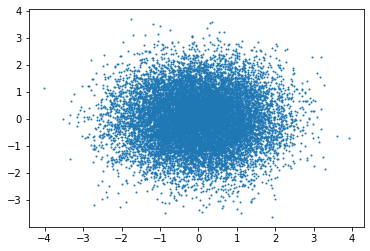

In [85]:
dx = np.random.randn(len(onset_delay))
dy = np.random.randn(len(onset_delay))
plt.scatter(onset_delay+dx,onset_delay_mode+dy,s=1)

9676
0.0


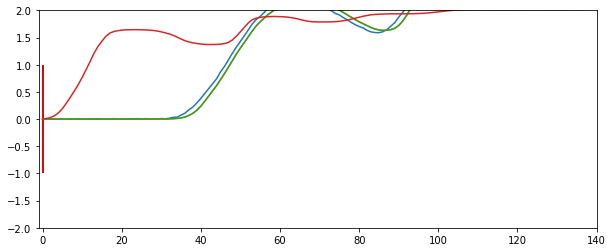

(-1.0, 140.0)

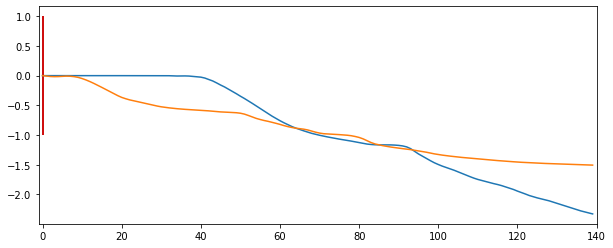

In [96]:
N = len(segments.onset)
i =  6733#
i = 3932
id_diff = np.where(np.abs(onset_delay_mode-onset_delay)>10)[0]
#i = np.random.choice(id_diff)#
i = 9676#np.random.randint(N)
print(i)
on_ = segments.onset[i] 
sg = 1 if bout_category[i]<13 else -1

j = id_nearest_template[i]
d = onset_delay[i]
print(d)
plt.figure(figsize=(10,4))
plt.plot(tracking_data.body_angle[on_:on_+200]-tracking_data.body_angle[on_])
plt.plot(clean_traj.body_angle[on_:on_+200]-clean_traj.body_angle[on_])
plt.plot(traj_array[i,2,:])

plt.plot(pipeline.knn_training_dataset.traj[j,2,:])
plt.vlines(d,-1,1,'k')
plt.vlines(onset_delay_mode[i],-1,1,'r')

k = len(pipeline.knn_training_dataset.delays)/(2*len(pipeline.knn_training_dataset.augmentation_delays))
jj = int(j%k)
t = np.arange(0,140)
#plt.plot(t+d,sg*pipeline.knn_training_dataset.traj[jj,2,:])
plt.ylim(-2,2)
plt.xlim(-1,140)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(traj_array[i,0,:])
plt.plot(pipeline.knn_training_dataset.traj[j,0,:])

plt.vlines(d+0.1,-1,1,'k')
plt.vlines(onset_delay_mode[i],-1,1,'r')
plt.xlim(-1,140)


In [ ]:
# Idea:

# First refine Onset using Classifier
# Use 0 delays classifier to get final category




In [70]:
np.mean(onset_delay_mode)

5.649633550488599

In [51]:
np.mean(onset_delay)

6.234324104234528

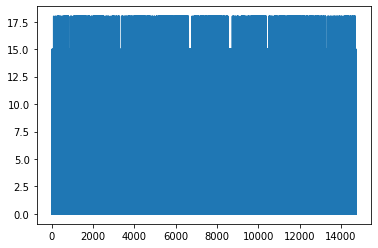

In [274]:
plt.plot(onset_delay)

In [269]:
np.unique(bout_category)

array([ 0,  1,  2,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 18, 19, 20,
       21, 22, 23, 24, 25])

In [52]:
#TODO: Make Bouts class containing:

# Onset,Offset (After Correction)

# Category + Name Category

# Nearest Template

In [5]:

import os
import json

# Data Wrangling
import h5py
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors


In [6]:
from utils.utils_plot import display_trajectory
from utils.utils import compute_outer_circle
from utils import smallestenclosingcircle as smallestenclosingcircle


from tracking_data.dataset import Dataset_CentroidTracking,Dataset_TailTracking

In [7]:
df = pd.read_csv('D:\ZebrafishMatlabCSV\CatchAllBouts_atlas_20200525_1551_df.csv')

x = df['x_blob'].values
y = df['y_blob'].values
body_angle = df['body_angle'].values
body_angle = np.arctan2(np.sin(body_angle),np.cos(body_angle))
body_angle = np.unwrap(body_angle)
# Center trajectory:
circle = compute_outer_circle(x,y)
x,y = x-circle[0],y-circle[1]


In [9]:
from super_resolution.downsampling import convert_frame_duration,create_downsampling_function
from super_resolution.downsampling import convert_ms_to_frames

In [10]:
# Downsample:
fps_new = 700
downsampling_f, Duration_after_Downsampling,t,tnew = create_downsampling_function(fps_new=fps_new,n_frames_origin=len(x),fps_origin=700)
#x_sub = downsampling_f(x,axis = 0)
#y_sub = downsampling_f(y,axis = 0)
#body_angle_sub = downsampling_f(body_angle,axis = 0)
tail_angle_sub = downsampling_f(tail_angle,axis = 0)

x_sub,y_sub,body_angle_sub  = map(lambda x : downsampling_f(x,axis=0),[x,y,body_angle])

tracking_data = Dataset_CentroidTracking(fps=fps_new,x=x_sub,y=y_sub,body_angle=body_angle_sub)

# Diagnostic Pipeline

#### PRE-PIPELINE PARAMETER TUNING:

* Check that trajectory make sense

* Set up 1 euro filter

* Set-up Find-peak prominence

#### POST-PIPELINE CHECK:

* Check delays of bouts after correction of onset

* Display clustered trajectory


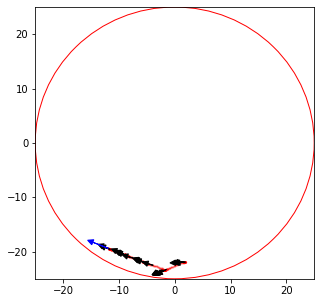

In [11]:
df_plot=pd.DataFrame(np.vstack((x_sub,y_sub,body_angle_sub)).T, 
columns=['x','y','angle'])
id = np.random.randint(df_plot.shape[0])
fig = display_trajectory(df_plot,index = id,past_memory=3*700)

## Setup 1 euro filter parameters

<font size="2">

The two parameters (fcmin and beta) can be set using a simple two-step procedure:
* First beta is set to 0 and fcmin (mincutoff) to a reasonable middle-ground value such as 1 Hz. Then the body part is held steady or moved at a very low speed while fcmin is adjusted to remove jitter and preserve an acceptable lag during these slow movements (decreasing fcmin reduces jitter but increases lag, fcmin must be > 0). 
* Next, the body part is moved quickly in different directions while beta is increased with a focus on minimizing lag. First find the right order of magnitude to tune beta, which depends on the kind of data you manipulate and their units: do not hesitate to start with values like 0.001 or 0.0001. You can first multiply and divide beta by factor 10 until you notice an effect on latency when moving quickly. 

Note that parameters fcmin and beta have clear conceptual relationships: if high speed lag is a problem, increase beta; if slow speed jitter is a problem, decrease fcmin.

</font>

In [12]:
# Define sample for tuning model:
IdSt = np.random.randint(x_sub.shape[0])
Duration = 10*fps_new
x_,y_,angle_ = x_sub[IdSt:IdSt+Duration],y_sub[IdSt:IdSt+Duration],body_angle_sub[IdSt:IdSt+Duration]

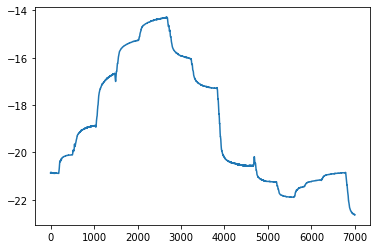

In [13]:
plt.plot(x_)

In [15]:
from preprocessing.smoothing import one_euro_filter

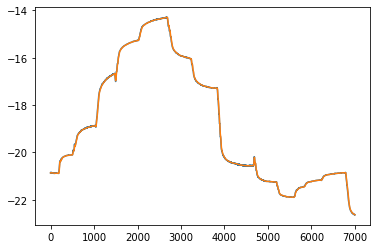

In [16]:
fc_min,beta = 20,1

smooth_func = lambda x : one_euro_filter(x,fc_min,beta,fps_new)
x_clean,y_clean,body_angle_clean  = map(smooth_func,[x_,y_,angle_])

IdSt,Duration = 0,len(x_)
plt.plot(x_[IdSt:IdSt+Duration])
plt.plot(x_clean[IdSt:IdSt+Duration])

In [17]:
help(convert_ms_to_frames)

Help on function convert_ms_to_frames in module super_resolution.downsampling:

convert_ms_to_frames(fps: int, duration: float) -> int
    Convert duration in ms to number of frames
    
    Args:
        fps (int): frame rate 
        duration (float): duration in ms
    
    Returns:
        int: number of frames correponding to duration



In [29]:
# Clean full data using set parameters:

smooth_func = lambda x : one_euro_filter(x,fc_min=20,beta=1,rate=fps_new)
x_sub,y_sub,body_angle_sub  = map(smooth_func,[x_sub,y_sub,body_angle_sub])


In [31]:
from preprocessing.preprocessing import create_preprocess_traj
# This should be in cfg class + convert in post_init
robust_diff_ms = 21
lag_ms = 85
bout_duration_ms = 200

bout_duration = convert_ms_to_frames(fps = fps_new,duration = bout_duration_ms)

preprocess = create_preprocess_traj(fps=fps_new,
                                         fc_min=fc_min,beta=beta,
                                         robust_diff_dt=robust_diff_ms,lag_dt=lag_ms)

clean_traj = preprocess(tracking_data.x,tracking_data.y,tracking_data.body_angle)

## Setup Peak Prominence in mobility

In [32]:
from scipy.signal import find_peaks


In [33]:

mobility = clean_traj.mobility

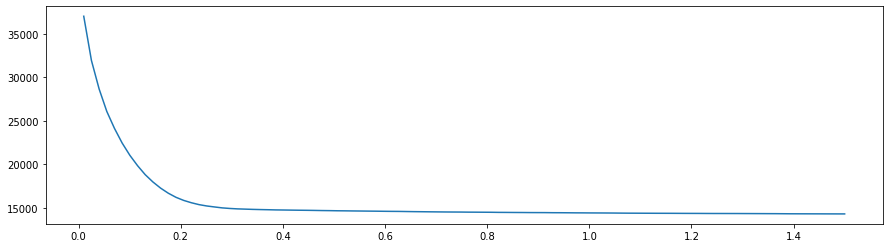

In [34]:
# Number of peak as function of prominence:
prom_para = np.linspace(0.01,1.5,100)
num_peaks = np.zeros_like(prom_para)
for i,pro in enumerate(prom_para):
    peaks, _ = find_peaks(mobility,distance=bout_duration,prominence=pro)
    num_peaks[i] = len(peaks)

plt.figure(figsize=(15,4))
plt.plot(prom_para,num_peaks)

# Next Segment and Classify:

In [35]:
prominence = 0.4

In [36]:
peaks, _ = find_peaks(mobility,distance=bout_duration,prominence=prominence)
peaks_bin = np.zeros(mobility.shape[0])
peaks_bin[peaks]=1

In [37]:
from segmentation.segment import segment_from_peaks,extract_aligned_traj,Segment

In [1]:
20*1000/700

28.571428571428573

In [173]:
onset_init,offset_init = segment_from_peaks(peaks=peaks,max_t=len(mobility),margin_before_peak=35)
segment = Segment(onset=onset_init,offset=offset_init,bout_duration=bout_duration)

In [174]:
traj_array = extract_aligned_traj(x = clean_traj.x,
                                  y = clean_traj.y,
                                  body_angle = clean_traj.body_angle,
                                  segment = segment)

In [176]:
min_delay_ms = 0#-15
max_delay_ms = 10#45#28
step_delay_ms = 4

min_delay,max_delay,step_delay = map(lambda x: convert_ms_to_frames(fps=fps_new,duration=x),[min_delay_ms,max_delay_ms,step_delay_ms])

In [177]:
knn_training_dataset = Knn_Training_Dataset(fps=700,augmentation_delays=np.arange(min_delay,max_delay,step_delay),ignore_CS=True)

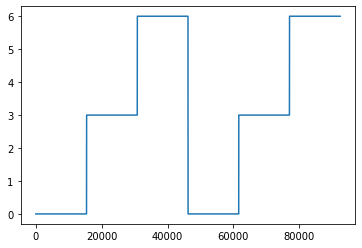

In [178]:
plt.plot(knn_training_dataset.delays)

In [179]:
feature_weight = np.array([0.4,0.4,2])
classifier = create_classifier(knn_training_dataset,feature_weight,n_neighbors=5,tracking_method='traj')

In [180]:
bout_category,onset_delay,id_nearest_template = classifier(traj_array)

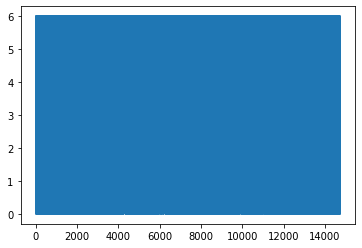

In [181]:
plt.plot(onset_delay)

14736
0.0


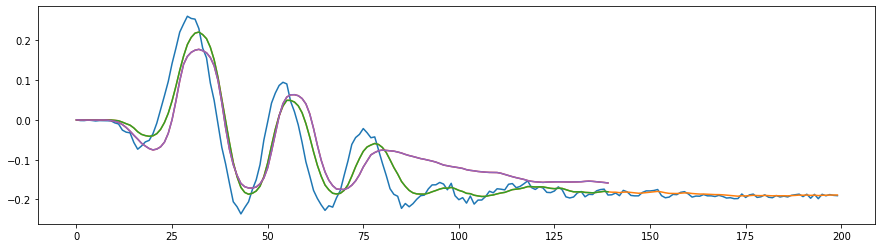

In [182]:
N = len(segment.onset)
print(N)
i =  6733#np.random.randint(N)
on_ = segment.onset[i]
sg = 1 if bout_category[i]<13 else -1

j = id_nearest_template[i]
d = onset_delay[i]
print(d)
plt.figure(figsize=(15,4))
plt.plot(tracking_data.body_angle[on_:on_+200]-tracking_data.body_angle[on_])
plt.plot(clean_traj.body_angle[on_:on_+200]-clean_traj.body_angle[on_])
plt.plot(traj_array[i,2,:])

plt.plot(knn_training_dataset.traj[j,2,:])

k = len(knn_training_dataset.delays)/(2*len(knn_training_dataset.augmentation_delays))
jj = int(j%k)
t = np.arange(0,140)
plt.plot(t+d,sg*knn_training_dataset.traj[jj,2,:])

plt.show()

In [157]:
i

6733

In [132]:
j%k

9331.0

(0.0, 15400.0)

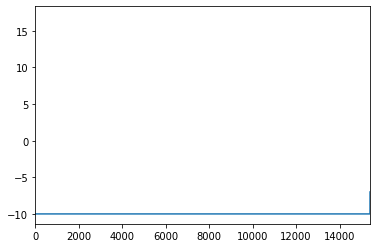

In [76]:
plt.plot(knn_training_dataset.delays)
plt.xlim(0,k)

In [185]:
# Quality Control

# Make fine adjustement to onset

# Declare Category

# Find Outliers

In [ ]:
# Collect bouts:

# -> feed preprocessed traj or preprocessed tail


In [ ]:
def create_classifier_segmenter_traj(classifier,prominence=0.25,Bout_Duration=140,Margin_before_peak=20):

    def classifier_segmenter_traj(mobility,traj):

        # SEGMENT AND EXTRACT BOUTS
        peaks, _ = find_peaks(mobility,distance=Bout_Duration,prominence=prominence)
        peaks_bin = np.zeros(mobility.shape[0])
        peaks_bin[peaks]=1
        onset,offset =  segment_from_peaks(peaks,T = len(mobility), Margin_before_peak=Margin_before_peak, Bout_Duration=Bout_Duration)
        bouts_array,bouts_array_flat = collect_bouts_traj(traj,onset,offset,Bout_Duration)

        # CLASSIFY:
        bout_cat,delay_pred,id_nearest = classifier(bouts_array_flat)

        '''
        # REFINE SEGMENTATION:
        onset_corrected, offset_corrected = [],[]
        for i,(on_,off_) in enumerate(zip(onset,offset)):
            onset_corrected.append(int(on_+delay_pred[i]))
            offset_corrected.append(int(on_+delay_pred[i]+Bout_Duration))
        onset,offset = onset_corrected,offset_corrected

        # EXTRACT ALIGNED BOUTS: 

        bouts_array,bouts_array_flat = collect_bouts_traj(traj,onset,offset,Bout_Duration)
        bout_cat,delay_pred_post_align,id_nearest = classifier(bouts_array_flat)'''
        delay_pred_post_align = delay_pred
        bout_cat_ts,bout_cat_ts_signed = compute_bout_cat_ts(onset,offset,bout_cat,tail_angle.shape[0])

        return bouts_array,bouts_array_flat,onset,offset,bout_cat,bout_cat_ts,bout_cat_ts_signed,delay_pred_post_align,delay_pred,id_nearest
        
    return classifier_segmenter_traj

# PIPELINE:

In [17]:
from preprocessing.trajectory import create_preprocess_traj

from segmentation.segment import create_segmentation_from_mobility
from segmentation.segment import segment_from_peaks,collect_bouts_traj

from classification.template_bouts import generate_template_bouts
from classification.classify import create_classifier

from utils.utils_plot import NameCatSym_w_CS,list_color_w_CS,cmp_bouts
from utils.utils_bouts import compute_bout_cat_ts

In [19]:
def create_pipeline_traj(preprocess,classifier_segmenter_traj):

    def pipeline(x,y,body_angle):

        mobility,traj = preprocess(x,y,body_angle)

        bouts_array,bouts_array_flat,onset,offset,bout_cat,bout_cat_ts,bout_cat_ts_signed,delay_pred_post_align,delay_pred,id_nearest = classifier_segmenter_traj(mobility,traj)
        
        return bouts_array,bouts_array_flat,onset,offset,bout_cat,bout_cat_ts,bout_cat_ts_signed,delay_pred_post_align,delay_pred,id_nearest,mobility,traj

    return pipeline

In [20]:
from classification.template_bouts import generate_template_bouts
from super_resolution.downsampling import convert_duration

0


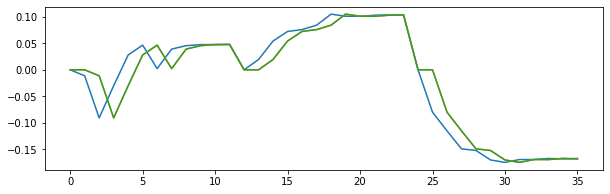

In [21]:
# LOAD TEMPLATES
Min_Delay = convert_duration(-10,original_fps=700,new_fps=new_fps)
print(Min_Delay)
Max_Delay = convert_duration(20,original_fps=700,new_fps=new_fps)
Step_Delay = convert_duration(3,original_fps=700,new_fps=new_fps)

templates_flat,templates_labels,templates_delays,NameCat,Duration_after_Downsampling = generate_template_bouts(format='traj',target_fps=new_fps,ExludeCaptureSwim=True,delays=np.arange(Min_Delay,Max_Delay,Step_Delay))

M = int(len(np.unique(templates_delays)))
N = int(len(templates_delays)/(M*2))
plt.figure(figsize=(10,3))
plt.plot(templates_flat[0,:])
plt.plot(templates_flat[0+N*int(np.round(M/2)),:])
plt.plot(templates_flat[0+N*(M-1),:])
plt.show()

In [52]:
# Pipeline Parameters:
fc_min,beta=20,1
Ndiff = convert_duration(15,original_fps=700,new_fps=new_fps)
if Ndiff%2==0:
    Ndiff=Ndiff+1
Bout_Duration = convert_duration(140,original_fps=700,new_fps=new_fps)
Lag_dt = convert_duration(60,original_fps=700,new_fps=new_fps)
print(Bout_Duration)
Lag_dt = Bout_Duration
Margin_before_peak=convert_duration(20,original_fps=700,new_fps=new_fps)
prominence = 0.2

12


In [53]:
preprocess = create_preprocess_traj(fps=new_fps,fc_min=fc_min,beta=beta,Ndiff=Ndiff,Lag_dt=Lag_dt)
classifier = create_classifier(templates_flat,templates_labels,templates_delays,scale=[0.4,0.4,2],n_neighbors=50,Bout_Duration=Bout_Duration)
classifier_segmenter_traj = create_classifier_segmenter_traj(classifier,prominence=prominence,Bout_Duration=Bout_Duration,Margin_before_peak=Margin_before_peak)
pipeline_traj = create_pipeline_traj(preprocess,classifier_segmenter_traj)

In [54]:
bouts_array,bouts_array_flat,onset,offset,bout_cat,bout_cat_ts,bout_cat_ts_signed,delay_pred_post_align,delay_pred,id_nearest,mobility,traj = pipeline_traj(x_input,y_input,body_angle_input)

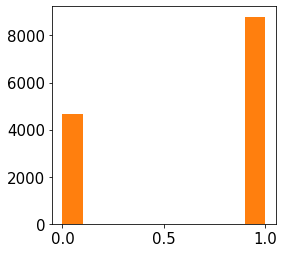

In [55]:
plt.figure(figsize=(4,4))
plt.hist(delay_pred)
plt.hist(delay_pred_post_align)
plt.show()

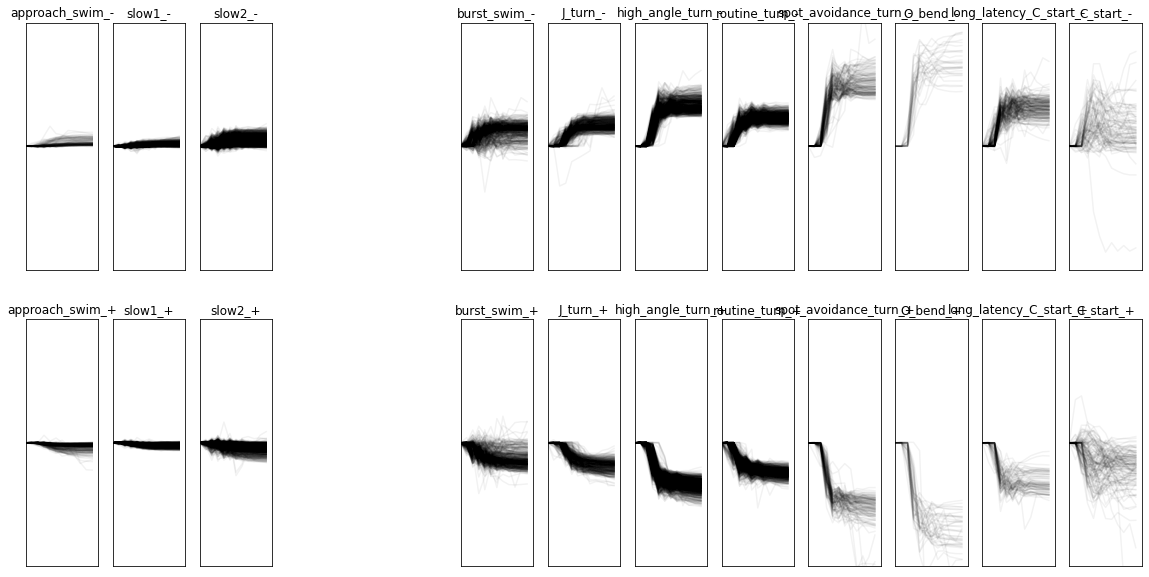

In [56]:
import matplotlib.gridspec as gridspec
from matplotlib import colors

fig, ax = plt.subplots(facecolor='white',figsize=(20,10)) 

G = gridspec.GridSpec(2,13)
ax0 = {}

for k,b in enumerate(np.unique((templates_labels))):
    b = int(b)
    sg = 1 if b<13 else -1
    ax0 = plt.subplot(G[int((sg+1)*1/2),b%13])
    ax0.set_title(NameCat[b])
    
    
    id = np.where(bout_cat==b)[0]       
    if len(id)>0:
        id = id[0:1000]
        ax0.plot(bouts_array_flat[id,2*Bout_Duration:].T,'k',alpha=0.05)

    ax0.set_xlim(0,Bout_Duration*1)
    ax0.set_ylim(-3.6,3.6)
    
    ax0.set_xticks([])
    ax0.set_yticks([])
    
plt.show()


In [57]:
from classification.benchmark_w_matlab import compute_bout_cat_matlab
from scipy import stats

onset_mat,offset_mat,bout_cat_matlab,bout_cat_ts_matlab,bout_cat_ts_signed_matlab = compute_bout_cat_matlab(df,new_fps=new_fps,old_fps=700)

label_mat = []
label_py = []

for i,(on_,off_) in enumerate(zip(onset_mat,offset_mat)):
    tmp = bout_cat_ts[on_:off_]
    tmp = tmp[tmp>-1]
    if len(tmp)>0:
        label_mat.append(bout_cat_matlab[i])
        label_py.append(stats.mode(tmp)[0][0])

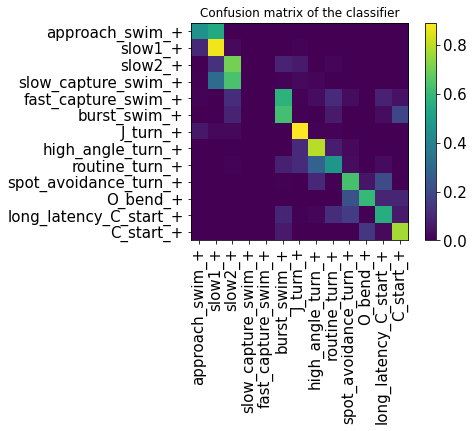

In [58]:
from sklearn.metrics import confusion_matrix
x = np.array(label_mat)
y = np.array(label_py)

cm = confusion_matrix(x, y, labels = np.arange(13),normalize='true')#{‘true’, ‘pred’, ‘all’,'none})
plt.imshow(cm)
plt.title('Confusion matrix of the classifier')
plt.colorbar()
plt.xticks(np.arange(13),NameCat[0:13],rotation=90)
plt.yticks(np.arange(13),NameCat[0:13],rotation=0)
plt.show()

In [59]:
# Accuracy:
x_noCS = x[(x!=3)&(x!=4)]
y_noCS = y[(x!=3)&(x!=4)]

In [60]:
from sklearn.metrics import f1_score
f1_score(x_noCS, y_noCS, average='macro')

0.5691877275099777

In [61]:
from sklearn.metrics import accuracy_score
accuracy_score(x_noCS, y_noCS)

0.6800840336134454

In [63]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(x_noCS, y_noCS)

0.6706491855447706


* 0.49 with KNN 5 SCALE 0 0 2
* 0.68.5 with KNN 5 SCALE 0.4 0.4 2
* 0.68 with KNN 1 SCALE 0.4 0.4 2
* 0.69 with KNN 50 SCALE 0.4 0.4 2
* 0.723 with KNN 50 SCALE 0.4 0.4 2 Delay -10,20


In [74]:

Duration = new_fps*7
IdSt = 7969693#
IdSt = np.random.randint(mobility.shape[0])
IdEd = IdSt + Duration
t = np.linspace(0,Duration/new_fps,Duration)
sub_onset,sub_offset,sub_i= [],[],[]

for i,(on_,off_) in enumerate(zip(onset,offset)):
    if (on_>IdSt)&(off_<IdEd):
        sub_onset.append(on_)
        sub_offset.append(off_)
        sub_i.append(i)

#sub_peaks = np.where(peaks_bin[IdSt:IdEd]==1)[0]
sub_i = np.array(sub_i)

sub_bouts_array_flat = bouts_array_flat[sub_i,:]
id = id_nearest[sub_i]
Nearest_bouts_x,Nearest_bouts_y,Nearest_bouts_angle = templates_flat[id,:Bout_Duration],templates_flat[id,Bout_Duration:Bout_Duration*2],templates_flat[id,Bout_Duration*2:]

(0.0, 7.0)

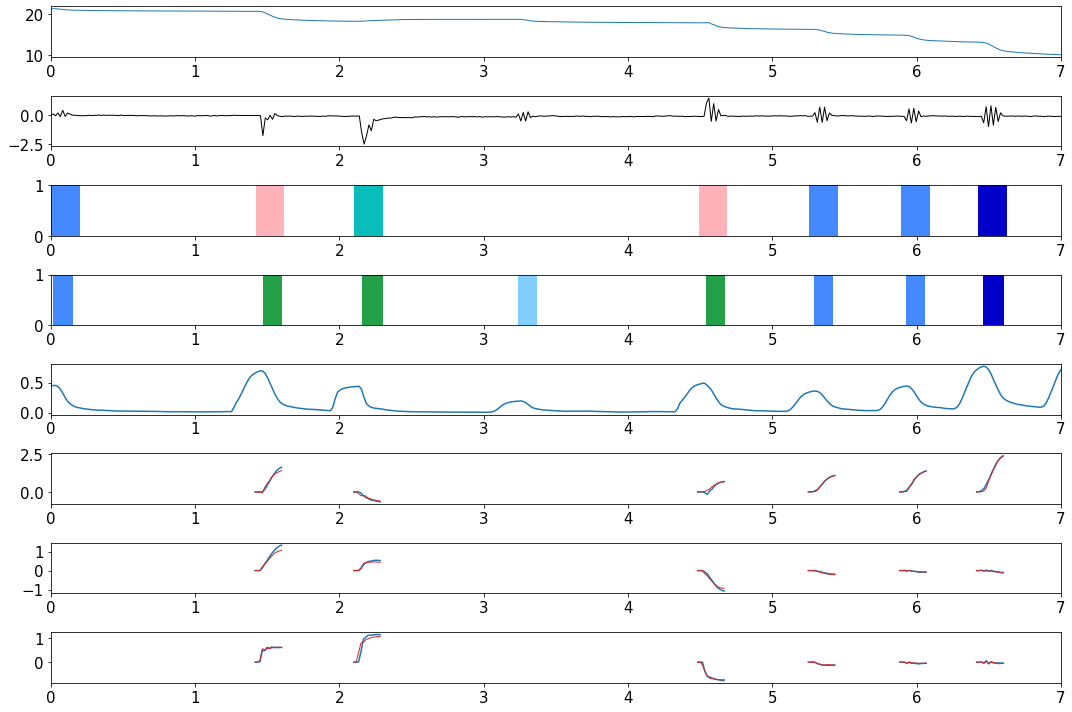

In [75]:

fig, ax = plt.subplots(facecolor='white',figsize=(15,10),tight_layout=True,sharex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)

G = gridspec.GridSpec(8,1)

ax = plt.subplot(G[0])
#ax.plot(t,tail_angle[IdSt:IdEd,7],'k',lw=1)
ax.plot(t,traj[IdSt:IdEd,0],lw=1)
ax.set_xlim(0,Duration/new_fps)

ax = plt.subplot(G[1])
ax.plot(t,tail_angle_sub[IdSt:IdEd,7],'k',lw=1)
#ax.plot(t,yaw_speed[IdSt:IdEd],lw=1)
#ax.plot(t,yaw_speed_hat_[IdSt:IdEd],lw=1)
ax.set_xlim(0,Duration/new_fps)

ax = plt.subplot(G[2])
ax.imshow(bout_cat_ts[IdSt:IdEd,np.newaxis].T,cmap=cmp_bouts,aspect='auto',vmin=0,vmax=12,interpolation='nearest',extent=[0,Duration/new_fps,0,1])
ax.set_xlim(0,Duration/new_fps)

ax = plt.subplot(G[3])
ax.imshow(bout_cat_ts_matlab[IdSt:IdEd,np.newaxis].T,cmap=cmp_bouts,aspect='auto',vmin=0,vmax=12,interpolation='nearest',extent=[0,Duration/new_fps,0,1])
ax.set_xlim(0,Duration/new_fps)

ax = plt.subplot(G[4])
ax.plot(t,mobility[IdSt:IdEd])
#y =-(1-2*(np.max((z[IdSt:IdEd]),axis=1)>np.max(-(z[IdSt:IdEd]),axis=1)))*np.max(np.abs(z[IdSt:IdEd]),axis=1)*peaks_bin[IdSt:IdEd]
#ax.scatter(t[sub_peaks],y[sub_peaks],color = 'r')
#for p in sub_peaks:
#    ax.add_patch(Rectangle((t[p],-10),140/700,20,facecolor="red",alpha=0.3))
ax.set_xlim(0,Duration/new_fps)


ax = plt.subplot(G[5])
for i,(on_,off_) in enumerate(zip(sub_onset,sub_offset)):
    ax.plot((np.arange(on_,off_)-IdSt)/new_fps,sub_bouts_array_flat[i,:Bout_Duration],'tab:blue')
    off_ = on_+Bout_Duration
    ax.plot((np.arange(on_,off_)-IdSt)/new_fps,Nearest_bouts_x[i,:],'tab:red',lw=1)
ax.set_xlim(0,Duration/new_fps)

ax = plt.subplot(G[6])
for i,(on_,off_) in enumerate(zip(sub_onset,sub_offset)):
    ax.plot((np.arange(on_,off_)-IdSt)/new_fps,sub_bouts_array_flat[i,Bout_Duration:Bout_Duration*2],'tab:blue')
    off_ = on_+Bout_Duration
    ax.plot((np.arange(on_,off_)-IdSt)/new_fps,Nearest_bouts_y[i,:],'tab:red',lw=1)
ax.set_xlim(0,Duration/new_fps)


ax = plt.subplot(G[7])
for i,(on_,off_) in enumerate(zip(sub_onset,sub_offset)):
    ax.plot((np.arange(on_,off_)-IdSt)/new_fps,sub_bouts_array_flat[i,Bout_Duration*2:],'tab:blue')
    off_ = on_+Bout_Duration
    ax.plot((np.arange(on_,off_)-IdSt)/new_fps,Nearest_bouts_angle[i,:],'tab:red',lw=1)
ax.set_xlim(0,Duration/new_fps)

In [38]:
i = 7

plt.figure()
plt.plot(sub_bouts_array_flat[7,:Bout_Duration*1])
plt.plot(Nearest_bouts_x[7,:])
plt.show()

plt.figure()
plt.plot(sub_bouts_array_flat[7,:Bout_Duration*1])
plt.plot(Nearest_bouts_x[7,:])
plt.show()

plt.figure()
plt.plot(sub_bouts_array_flat[7,Bout_Duration*2:])
plt.plot(Nearest_bouts_angle[7,:])
plt.show()


IndexError: index 7 is out of bounds for axis 0 with size 6

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(sub_bouts_array_flat[4,Bout_Duration*2:])
plt.plot(Nearest_bouts_angle[4,:])

# Approximate Trajectory from NN:

In [ ]:
from utils.utils import robust_diff
from segmentation.threshold import estimate_threshold_using_GMM

In [ ]:
traj_cumul = np.cumsum(np.abs(traj_speed),axis=0)

dt = 1000/new_fps*Lag_dt
displacement = np.zeros_like(traj_cumul)
Lag_dt = 14
for i in range(3):
    tmp= np.copy(traj_cumul[:,i])
    tmp_future_lag=shift(tmp,-Lag_dt, cval=0)
    displacement[:,i]=(tmp_future_lag-tmp)/dt

displacement[:Lag_dt,:] = 0
displacement[-Lag_dt:,:] = 0

mobility = np.linalg.norm(displacement,axis=1)

'''
mobility_alt = np.zeros_like(traj_cumul)
for i in range(traj_cumul.shape[1]):
    mobility_alt[:,i]=robust_diff(traj_cumul[:,i],dt=1/new_fps, filter_length=11)
    mobility_alt[:,i] = mobility_alt[:,i]/np.nanstd(mobility_alt[:,i])
mobility_alt[np.isnan(mobility_alt)] = 0
'''

val = np.linalg.norm(mobility_alt,axis=1)
#val = mobility_alt[:,0]

In [ ]:
plt.plot(mobility_alt[IdSt:IdEd,:])
plt.plot(-mobility[IdSt:IdEd])

In [ ]:
bin_ = np.ones_like(val).astype('bool')

for i in range(3):
    BT,ax = estimate_threshold_using_GMM(mobility_alt[:,i],margin_std=1.8,axis=None)
    bin_ = bin_&(mobility_alt[:,i]>BT)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(15,4))
BT,ax = estimate_threshold_using_GMM(mobility[:],margin_std=1.8,axis=ax)
print(BT)

In [ ]:

Duration = new_fps*7
IdSt = np.random.randint(mobility.shape[0])
IdEd = IdSt + Duration
t = np.linspace(0,Duration/new_fps,Duration)

plt.figure(figsize=(20,4))
plt.plot(t,tail_angle_sub[IdSt:IdEd,7])
plt.plot(t,mobility[IdSt:IdEd]/2)
x = peaks_bin[IdSt:IdEd]
plt.scatter(t[x>0],x[x>0],s=50,color='r')
#plt.plot(t,val[IdSt:IdEd]>BT)
#plt.plot(t,bin_[IdSt:IdEd])
#plt.plot(t,mobility[IdSt:IdEd]>BT)

plt.show()

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(mobility_alt[IdSt:IdEd,:])
plt.plot(-val[IdSt:IdEd])

# Save to Plotly

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return pl_colorscale


cmp_bouts = colors.ListedColormap(['#FFFFFF'] + list_color_w_CS)
cmp_bouts_pltly = matplotlib_to_plotly(cmp_bouts, 255)


In [ ]:
t.shape

In [ ]:
df.head(10)

In [ ]:
plt.plot(df.bout_cat_matlab.values,'.')

In [ ]:
t = np.arange(0,len(mobility))

fig = make_subplots(rows=3, cols=1,shared_xaxes=True)


for pl in px.imshow(bout_cat_signed.T, x=t, y=np.arange(2)).data:
    fig.add_trace(pl, row=1, col=1)

for pl in px.imshow(df.bout_cat_matlab.values[np.newaxis,:], x=t, y=np.arange(1)).data:
    fig.add_trace(pl, row=2, col=1)


fig.add_trace(go.Scatter(x=t, y=mobility,mode='lines'),
              row=3, col=1)

layout = px.imshow(bout_cat_signed.T,x= t,color_continuous_scale=cmp_bouts_pltly,zmin=-1,zmax=12).layout
fig.layout.coloraxis = layout.coloraxis

fig.update_traces(xaxis="x")

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.write_html("super_resolution_pipeline.html")
